In [13]:
#importing libraries and file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import scipy.stats
%matplotlib inline

df = pd.read_csv(r".\supermarket_sales.csv")
pd.set_option('display.max_columns', 200)

print(df.shape)
display(df.head())


(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#checking data consistency
print(df.dtypes)
print(df.isna().sum())

Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object
Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs          

Two sample test (unpaired)

H0: Total amount is the same by gender
H1: total amount is higher for women compared to men

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype

Text(0.5, 1.0, 'QQ Plot - Normality test')

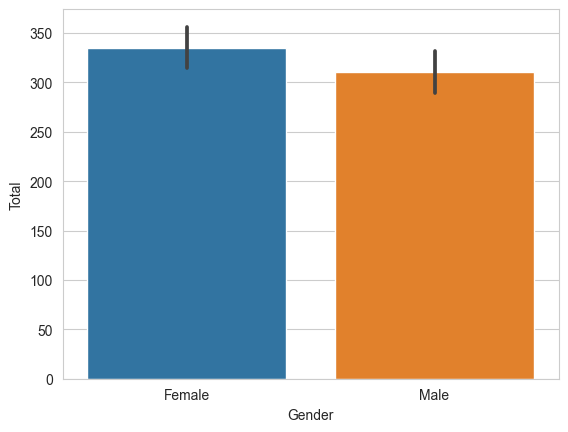

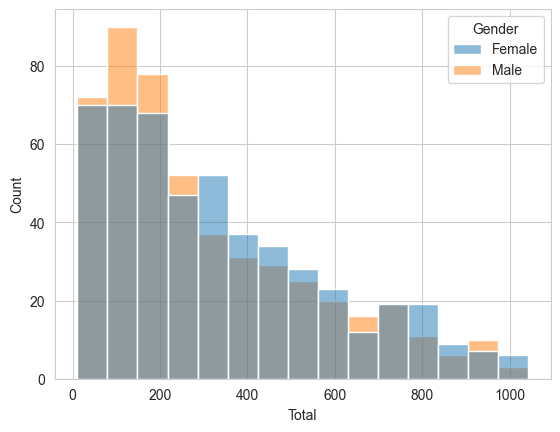

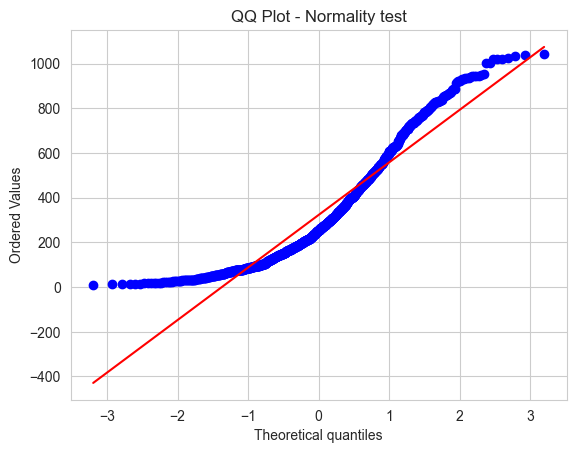

In [61]:
sns.set_style("whitegrid")
sns.barplot(data= df, x= "Gender", y="Total")

fig1, ax1 = plt.subplots()
sns.histplot(df, x="Total", hue="Gender")

fig2, ax2=plt.subplots()
scipy.stats.probplot(df["Total"], dist="norm", plot=plt)
plt.title("QQ Plot - Normality test")






In [48]:

display(scipy.stats.ttest_ind(df[df["Gender"]=="Female"]["Total"], df[df["Gender"]=="Male"]["Total"], alternative='greater', equal_var=False))
display(pingouin.ttest(df[df["Gender"]=="Female"]["Total"], df[df["Gender"]=="Male"]["Total"], alternative='greater', paired=False))

display(pingouin.mwu(df[df["Gender"]=="Female"]["Total"], df[df["Gender"]=="Male"]["Total"], alternative='greater'))
display(scipy.stats.mannwhitneyu(df[df["Gender"]=="Female"]["Total"], df[df["Gender"]=="Male"]["Total"], alternative='greater'))




TtestResult(statistic=1.5642197047338087, pvalue=0.05904160280232887, df=997.3404314560546)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.56422,997.340431,greater,0.059042,"[-1.28, inf]",0.098924,0.472,0.467408


,U-val,alternative,p-val,RBC,CLES
MWU,132497.5,greater,0.050315,-0.059984,0.529992


MannwhitneyuResult(statistic=132497.5, pvalue=0.05031546124568771)

Hacer test de product lines por Customer type o City

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Product line', ylabel='count'>

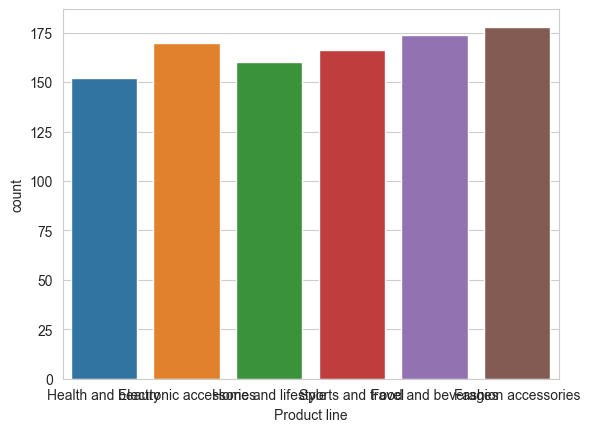

In [11]:
sns.countplot(data=df, x="Product line")